# Time series forcasting

Hourly energy consumption dataset
- Video: https://www.youtube.com/watch?v=vV12dGe_Fho&ab_channel=RobMulla

Stationary or non-stationary data

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [85]:
df = pd.read_csv("./PJME_hourly.csv",index_col=0)
df.index = pd.to_datetime(df.index)
#df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [86]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


<AxesSubplot: xlabel='Datetime'>

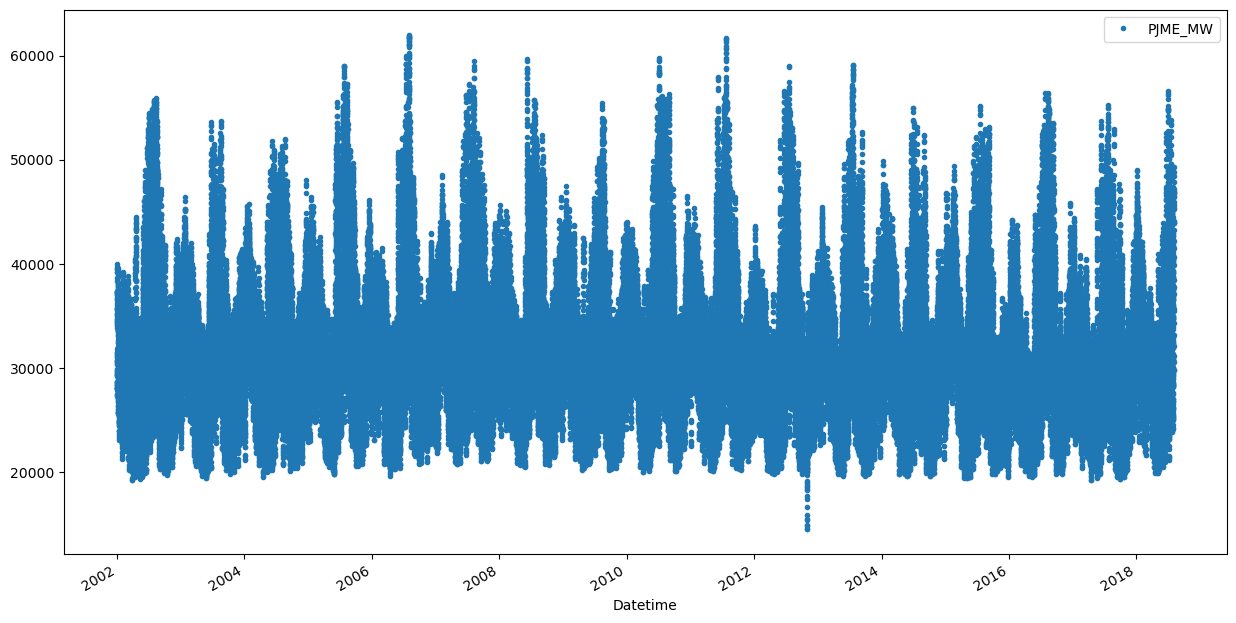

In [87]:
color_pal = sns.color_palette()
df.plot(style='.',figsize=(15,8),color=color_pal[0])

<AxesSubplot: xlabel='Datetime'>

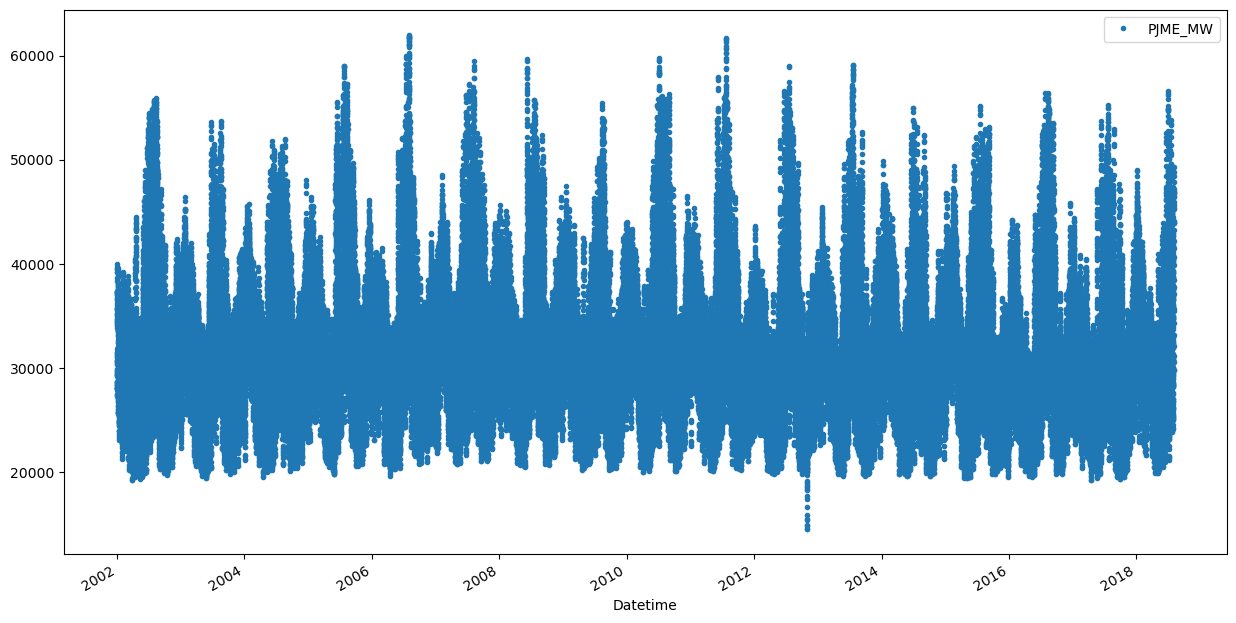

In [88]:
# Datatime index is an object, so we need to convert to
df.index = pd.to_datetime(df.index)
df.plot(style='.',figsize=(15,8),color=color_pal[0])

# Train / Test split
(Avoiding cross validation)


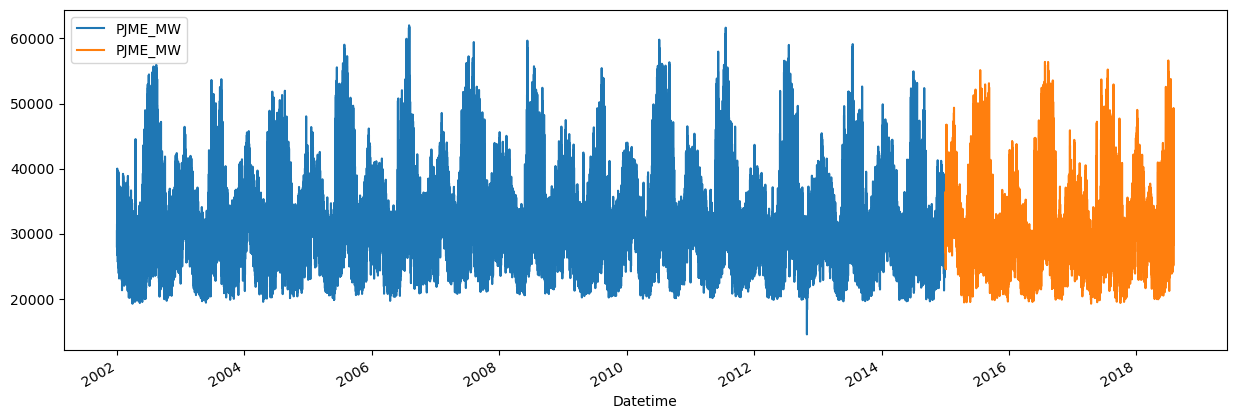

In [89]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index > "01-01-2015"]

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",color=color_pal[0])
test.plot(ax=ax,label="test",color=color_pal[1])
plt.legend()
plt.show()

# Analyze one week of data

<AxesSubplot: xlabel='Datetime'>

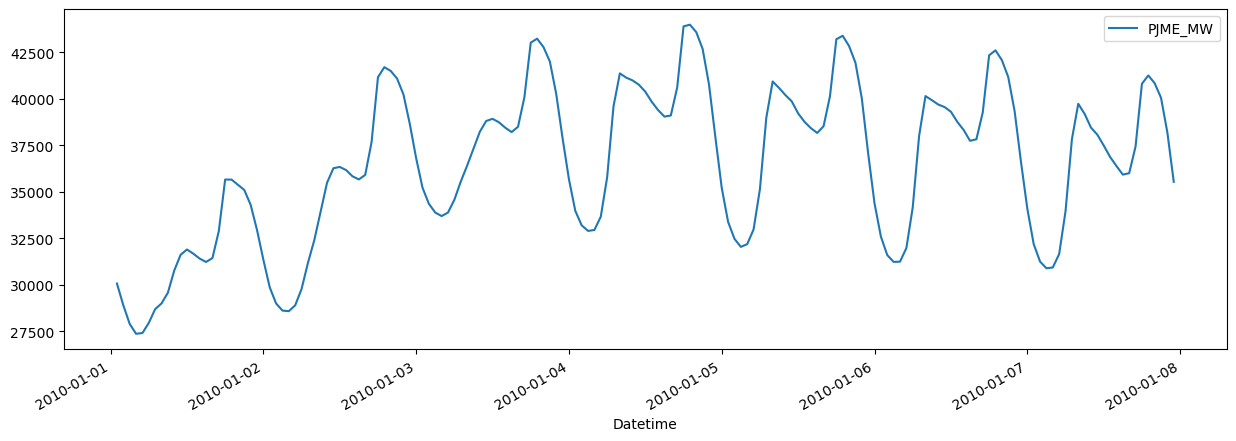

In [90]:
df_week = df.loc[((df.index > "01-01-2010") & (df.index < "01-08-2010"))]
df_week.plot(figsize=(15,5))

## Observation:  
Variations found within a given day
(Two peaks are common for energy consumption) & Weekend effect

# Feature Creation

In [91]:
def create_features(df):
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    #df["week"] = df.index.week
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.day_of_year
    return df
df = create_features(df)

# Plot the feature to target relation
Using box plot (show distribution of the dataset)


Text(0.5, 1.0, 'MW by hour')

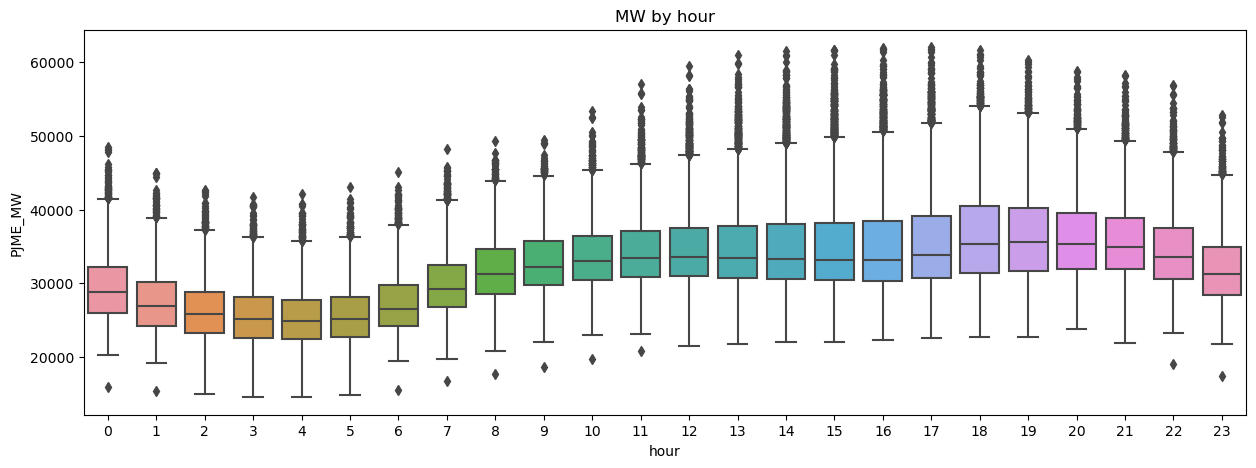

In [92]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x="hour",y="PJME_MW")
ax.set_title("MW by hour")

Text(0.5, 1.0, 'MW by hour')

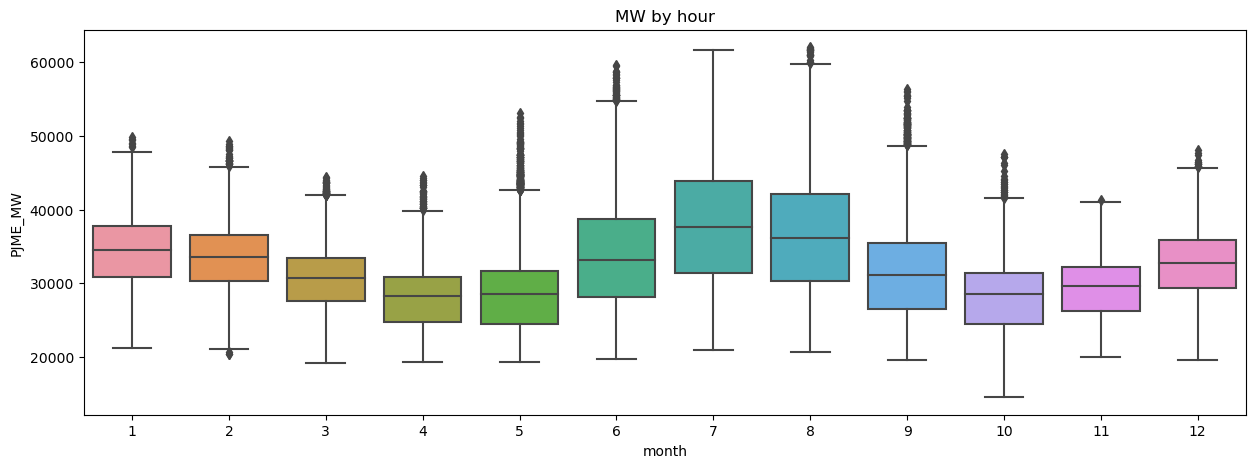

In [93]:
fig,ax=plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x="month",y="PJME_MW")
ax.set_title("MW by hour")

Tho peaks here show the summer AC crave and winder heater crave

# Create model

In [98]:
train = create_features(train)
test = create_features(test)

l = df.keys().to_list()
l.remove("PJME_MW")
FEATURES = l
TARGET = "PJME_MW"
print(FEATURES)
print(TARGET)

['hour', 'dayofweek', 'month', 'year', 'quarter', 'dayofyear']
PJME_MW


In [99]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [102]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50, # prevents overfitting
                       learning_rate = 0.01
                       )
reg.fit(X_train, y_train, 
        eval_set=[(X_train,y_train), (X_test,y_test)],
        verbose=5)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.26256
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.79851
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.71466
[15]	validation_0-rmse:28099.33236	validation_1-rmse:27143.89541
[20]	validation_0-rmse:26744.75390	validation_1-rmse:25791.21342
[25]	validation_0-rmse:25457.49135	validation_1-rmse:24506.70819
[30]	validation_0-rmse:24234.04380	validation_1-rmse:23287.89239
[35]	validation_0-rmse:23071.66967	validation_1-rmse:22130.16353
[40]	validation_0-rmse:21967.27772	validation_1-rmse:21029.59270
[45]	validation_0-rmse:20918.17175	validation_1-rmse:19985.21383
[50]	validation_0-rmse:19921.59089	validation_1-rmse:18994.45339
[55]	validation_0-rmse:18974.61485	validation_1-rmse:18057.06743
[60]	validation_0-rmse:18074.96747	validation_1-rmse:17172.17320
[65]	validation_0-rmse:17220.99639	validation_1-rmse:16329.40439
[70]	validation_0-rmse:16410.00894	validation_1-rmse:15524.97974
[75]	validation_0-rmse:1564

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importnace'}>

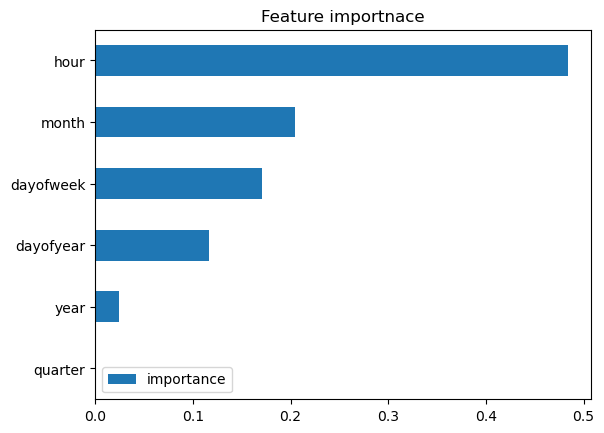

In [106]:
# Check feature importance with XGBoost
fi = pd.DataFrame(data=reg.feature_importances_,
                      index=reg.feature_names_in_,
                      columns=["importance"])
fi.sort_values("importance").plot(kind="barh",title="Feature importnace")
# SHows how much each feature was used when the trees were built

Most important features in building trees is hour and month
NOTE:  
_if features are very correlated_ this is not inforamtive

## Focasting on the test set

In [ ]:
test["prediction"] = reg.predict(X_test)

In [ ]:
df.merge(test, how="left", left_index=True, right_index=True)